# Get Weight Values with all imports

In [106]:
import json 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
# Import necessary libraries
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

mpl.rcParams.update(mpl.rcParamsDefault)
#import itertools
def l_0_norm(vector):
    count = 0
    total = 0
    for element in vector:
        for sub_element in element:
            if sub_element != 0:
                count += 1
    return count
def take_average(dict):
    data = dict["0"]
    iterations = list(dict.keys())
    total_iter = len(iterations)
    for iter in iterations:
        if iter == "0":
            continue
        for norm in dict[iter]:
            for style in dict[iter][norm]:
                for ratio in dict[iter][norm][style]:
                    for dataset in dict[iter][norm][style][ratio]:
                        value = np.array(dict[iter][norm][style][ratio][dataset])
                        data[norm][style][ratio][dataset] = (np.array(data[norm][style][ratio][dataset])+value)
                        if iter == iterations[-1]:
                            data[norm][style][ratio][dataset] = data[norm][style][ratio][dataset]/total_iter
    return data
def strip(name):
    name = name.split("/")[-1]
    name = name.split("_")[0]
    return name 
with open("result/all_distribution_new.json", 'r') as openfile:
    # Reading from json file
    all_distribution = json.load(openfile)
with open("result/distribution.json", 'r') as openfile:
    # Reading from json file
    new_distribution = json.load(openfile)
def loop_over(dict):
    if isinstance(dict, list):
        print("end")
    else: 
        print(dict.keys())
        for keys in dict:
            loop_over(dict[keys])

new_distribution = take_average(new_distribution)

# WANDA

In [ ]:
#"original","original-chat","commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"
module = "|W|_F"
original = new_distribution[module]["original"]
original_chat = new_distribution[module]["original-chat"]
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
for dataset in ["commonsense_qa","cais/mmlu","math_qa","derek-thomas/ScienceQA" ]:
    dataset_name = dataset.split('/')[-1]
    figure, axis = plt.subplots(ncols=4,figsize=(15, 6),layout="tight")
    for idx,ratio in enumerate(["5","5-chat","15","15-chat"]):
        if not(dataset_name in (new_distribution[module]["Wanda"][ratio].keys())):
            continue 
        if ratio.split("-")[-1] == "chat":
            difference = np.subtract(original_chat,new_distribution[module]["Wanda"][ratio][dataset_name])
        else:
            difference = np.subtract(original,new_distribution[module]["Wanda"][ratio][dataset_name])
        #cbar_kws = { 'ticks' : [0, 2] },cbar_kws = cbar_kws
        #g = sns.heatmap(difference, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer, vmin=0, vmax=2.5)
        g = sns.heatmap(difference, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
        g.set_xticklabels(g.get_xticklabels(), rotation = 27)
        axis[idx].set_title(f"Sparsity:{ratio}")
    figure.suptitle(r"Difference in $|W|_F$ value of pruned model: "+dataset_name.split('/')[-1])
    figure.tight_layout()
    plt.savefig(f"result/distribution/{dataset_name.split('/')[-1]}.png")
    plt.show()

## Albation Study for mixed dataset pruning

In [ ]:
dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["cais/mmlu","derek-thomas/ScienceQA"]]
for dataset_combine in dataset_both:
    newFolder = "_".join([d.split('/')[-1] for d in dataset_combine])
    ratio = "15-chat"
    original = "original-chat"
    dataset_name = [original, newFolder,dataset_combine[0],dataset_combine[1]]
    data = []
    idx = 0
    figure, axis = plt.subplots(ncols=3,figsize=(15, 6),layout="tight")
    #new_distribution[module]["Wanda"][ratio]
    mix = np.array(new_distribution[module][original])
    for dataset in dataset_name:
        dataset = dataset.split('/')[-1]
        if dataset == "original" or dataset == "original-chat" :
            data.append((dataset,np.array(new_distribution[module][dataset])))
        else:
            data.append((dataset,np.array(new_distribution[module]["Wanda"][ratio][dataset]))) 
            diff = np.subtract(mix,data[-1][1])
            g = sns.heatmap(diff, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
            g.set_xticklabels(g.get_xticklabels(), rotation = 27)
            axis[idx].set_title(f"{dataset}")
            idx += 1
    if ratio.split('-')[-1] == "chat":
        figure.suptitle(r"Difference in $|W|_F$ value of Llama-2-chat pruned model: "+ newFolder)
    else:
        figure.suptitle(r"Difference in $|W|_F$ value of Llama-2 pruned model: "+ newFolder)
    figure.tight_layout()
    plt.savefig(f"result/distribution/albation_architecture_{ratio}_{newFolder}.png")
    plt.show()
           
    difference = []
    label = []
    for (d1,arr1) in data:
        values = []
        for (d2,arr2) in data:
            M = l_0_norm(arr1-arr2)  #np.linalg.norm(arr1 - arr2,2) #
            values.append(M) 
        label.append(d1)
        difference.append(values)
    plt.figure(figsize=(15,8))
    if ratio.split('-')[-1] == "chat":
        plt.title(r"$||A_1 - A_2||_0$"+f": for Llama-2-Chat model: {ratio.split('-')[0]}% sparsity")
    else:
        plt.title(r"$||A_1 - A_2||_0$"+f": for Llama-2 model {ratio.split('-')[0]}% sparsity")
    g = sns.heatmap(np.array(difference),  annot=True, fmt=".2f",center=1,cmap=sns.color_palette("icefire", as_cmap=True),xticklabels=label,yticklabels=label)
    g.set_yticklabels(g.get_yticklabels(), rotation = 27)
    g.set_xticklabels(g.get_xticklabels(), rotation = 27)
    plt.tight_layout()
    plt.savefig(f"result/distribution/albation_{ratio}_{newFolder}.png")
    plt.show()


# LLM-PRUNER

## Compare two different pruned models

In [ ]:
module = "|W|_0"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"],"25":["25","25-chat"]}
plt.clf()
original = new_distribution[module]["original"]
original_chat = new_distribution[module]["original-chat"]
llm_pruner =  new_distribution[module]["LLM_Pruner"]
for sparsity in sparsity_model:
    sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
    for style in llm_pruner:
        figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight", sharex=True)
        for  idx, ratio in enumerate(sparsity_model[sparsity]):
            data = []
            #dataset = ["original","original-chat","commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
            dataset = ["original","original-chat","commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
            for dataset_name in dataset:
                dataset_name = dataset_name.split('/')[-1]
                if dataset_name == "original" or dataset_name == "original-chat":
                    data.append((dataset_name,np.array(new_distribution[module][dataset_name])))
                else:
                    data.append((strip(dataset_name),np.array(llm_pruner[style][ratio][dataset_name])))    
            

            #permutation = list(itertools.permutations(data, 2))
            difference = []
            label = []
            for (d1,arr1) in data:
                values = []
                for (d2,arr2) in data:
                    M = l_0_norm(np.subtract(arr1,arr2)) #np.linalg.norm(np.subtract(arr1,arr2),2) #
                    values.append(M)
                label.append(d1)
                difference.append(values)
            axis[idx].set_title(r"$||A_1 - A_2||_0$"+f": for Llama-2 {ratio}% sparsity ")
            g = sns.heatmap(np.array(difference),  annot=True, fmt=".2f",center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=label,yticklabels=label)
            g.set_yticklabels(g.get_yticklabels(), rotation = 27)
            g.set_xticklabels(g.get_xticklabels(), rotation = 27)
        figure.supylabel(r"$A_1$", fontsize=20)
        figure.supxlabel(r"$A_2$", fontsize=20)
        figure.suptitle(f"with LLM-Pruner {style.upper()} style, where A = {module}")
        plt.savefig(f"result/distribution/llm_pruner_{style}_{sparsity}_compare.png")
        plt.show()

<Figure size 640x480 with 0 Axes>

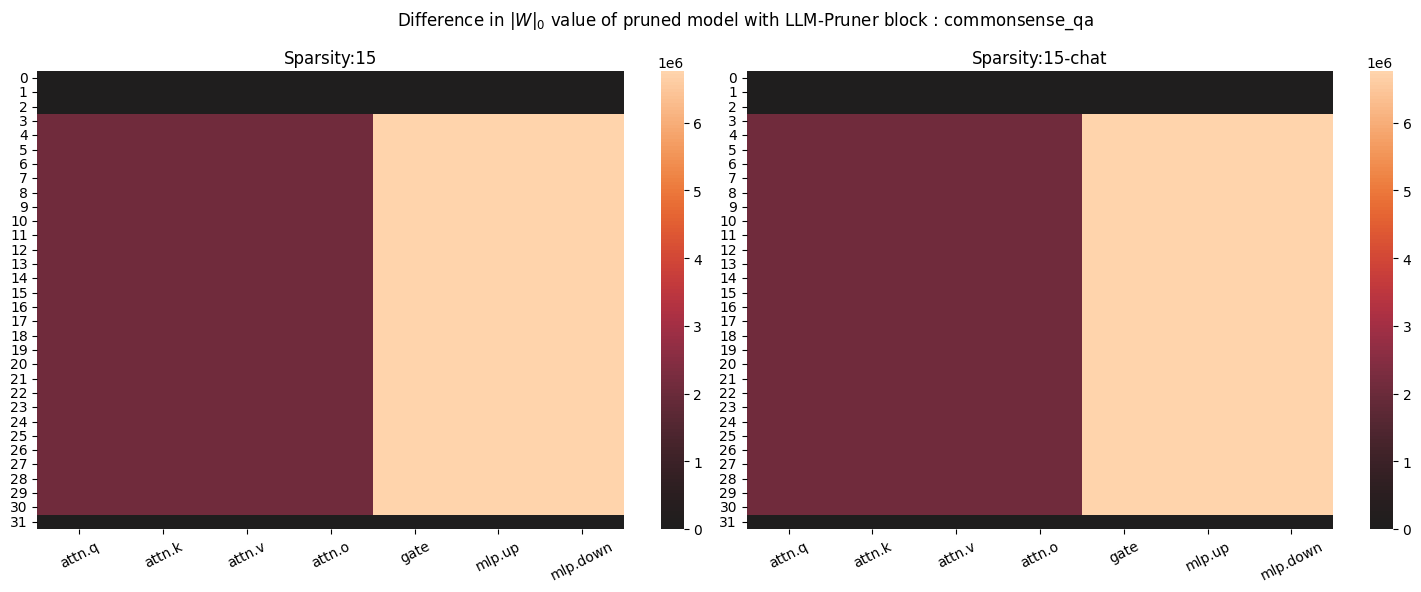

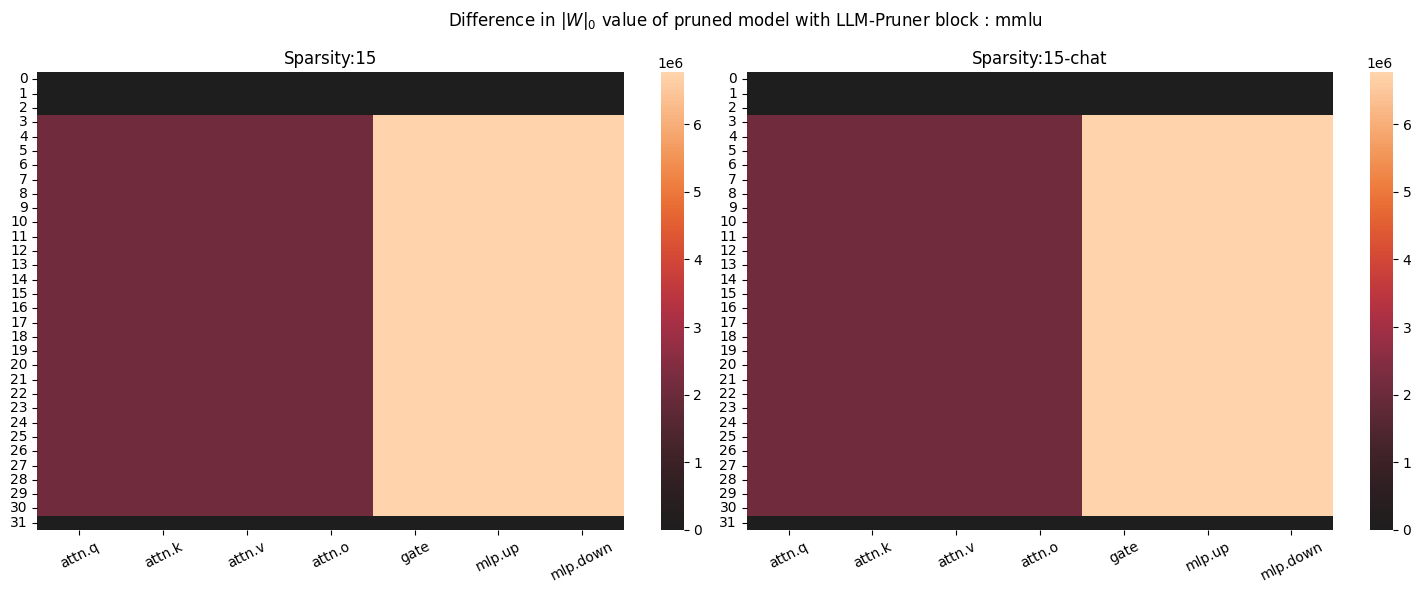

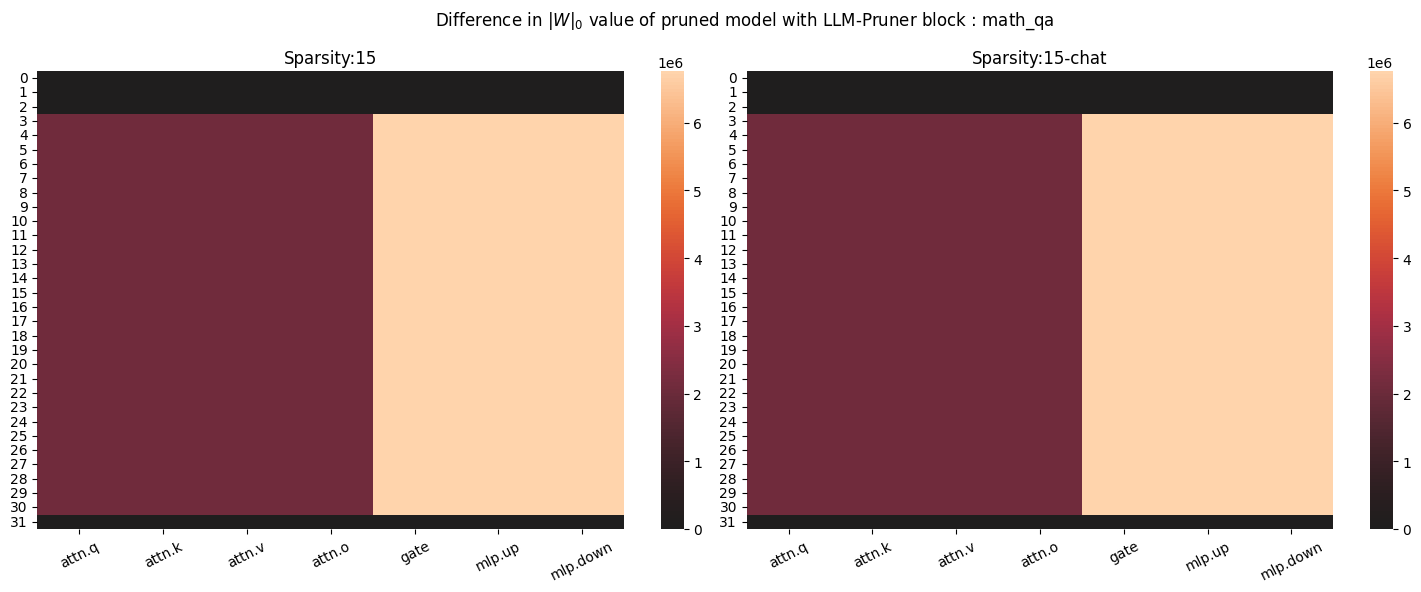

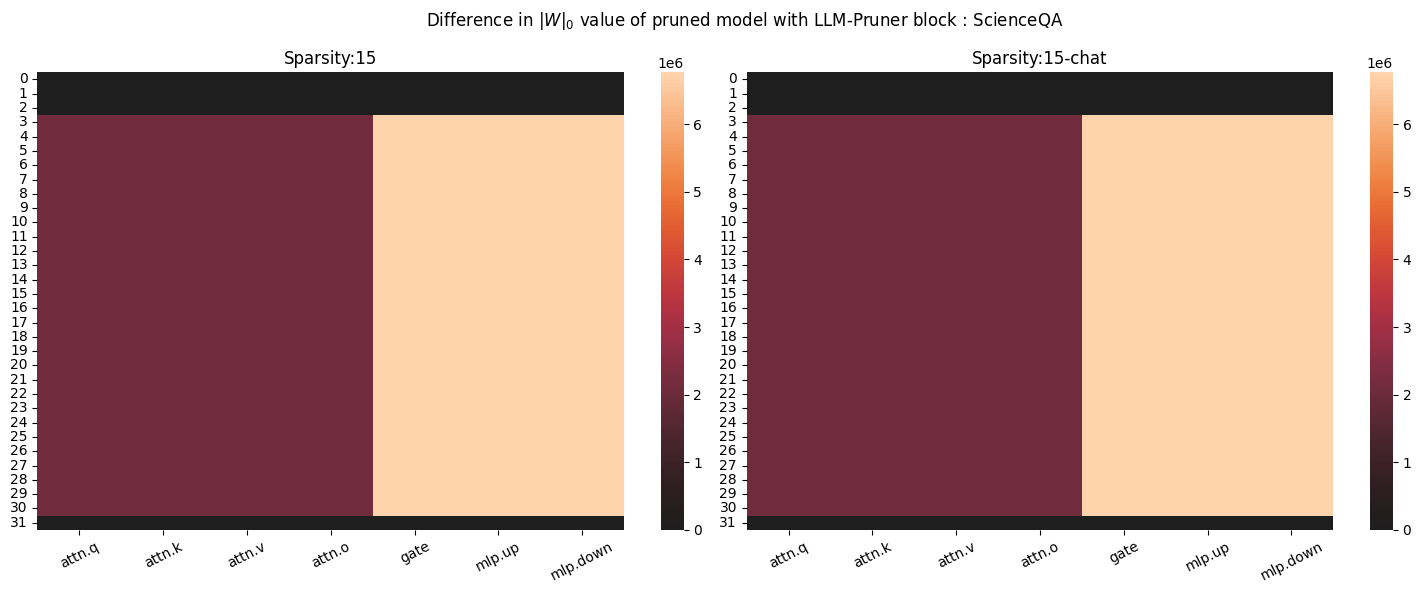

In [118]:
module = "|W|_0"
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
ratio_list = ["15","15-chat"]
plt.clf()
for style in ["block"]:
    #for dataset in ["commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
    for dataset in ["commonsense_qa","cais/mmlu","math_qa","derek-thomas/ScienceQA"]:
        dataset_name = dataset.split('/')[-1]
        figure, axis = plt.subplots(ncols=len(ratio_list),figsize=(15, 6),layout="tight")
        #for idx,ratio in enumerate(["5","5-chat","15","15-chat","25","25-chat"]):
        for idx,ratio in enumerate(ratio_list):
            if not(ratio in llm_pruner[style].keys()):
                print(ratio,style,dataset_name)
                continue 
            if ratio.split("-")[-1] == "chat":
                difference = np.subtract(original_chat,llm_pruner[style][ratio][dataset_name])
                #difference = llm_pruner[style][ratio][dataset_name]
            else:
                difference = np.subtract(original,llm_pruner[style][ratio][dataset_name])
                #difference = llm_pruner[style][ratio][dataset_name]
            g = sns.heatmap(difference, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
            g.set_xticklabels(g.get_xticklabels(), rotation = 27)
            axis[idx].set_title(f"Sparsity:{ratio}")
        if module == "|W|_F":
            figure.suptitle(r"Difference in $|W|_F$ value of pruned model with LLM-Pruner "+ style +" : "+dataset_name.split('/')[-1])
        else:
            figure.suptitle(r"Difference in $|W|_0$ value of pruned model with LLM-Pruner "+ style +" : "+dataset_name.split('/')[-1])
        #plt.savefig(f"result/distribution/llm_pruner_{style}_{dataset_name.split('/')[-1]}.png")
        plt.show()
#permutation = list(itertools.permutations(data, 2))

# Albation

block


<Figure size 640x480 with 0 Axes>

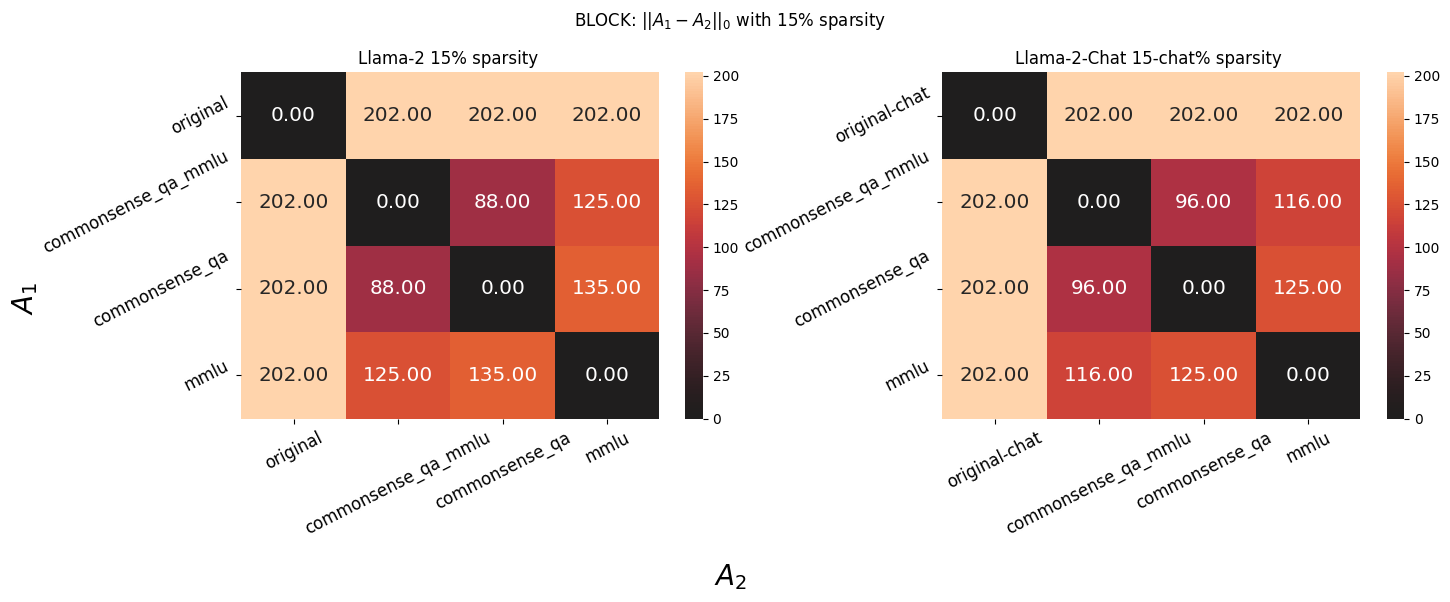

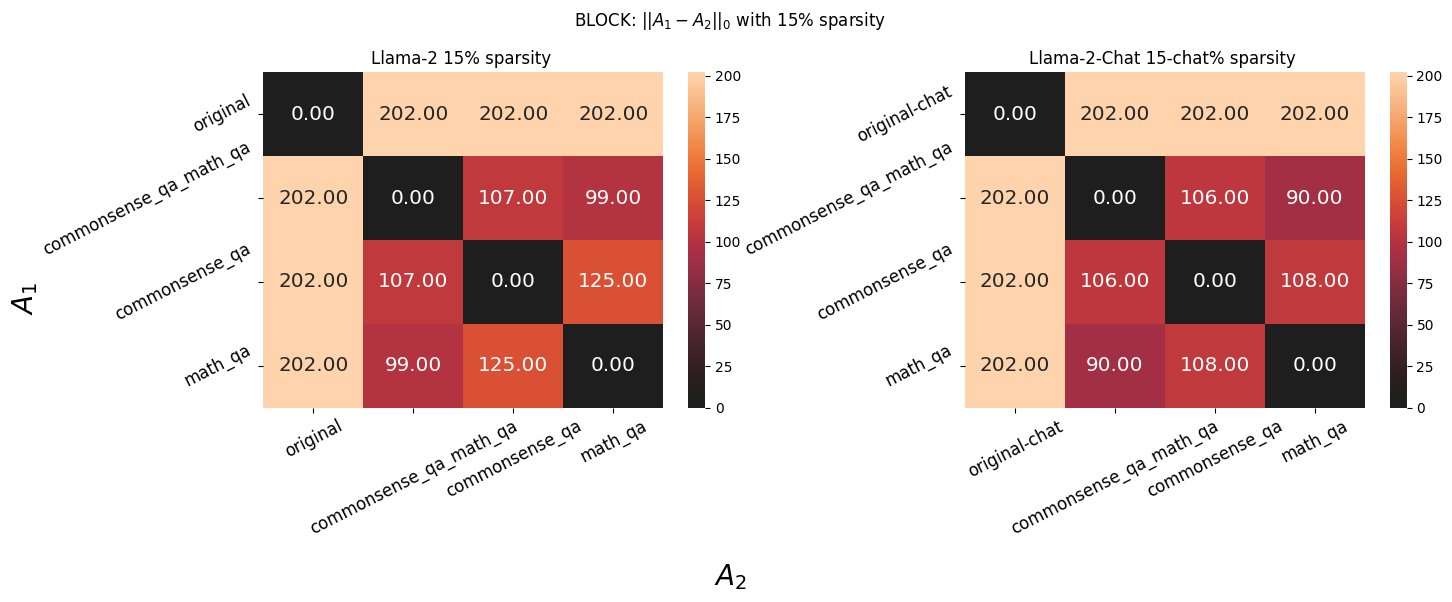

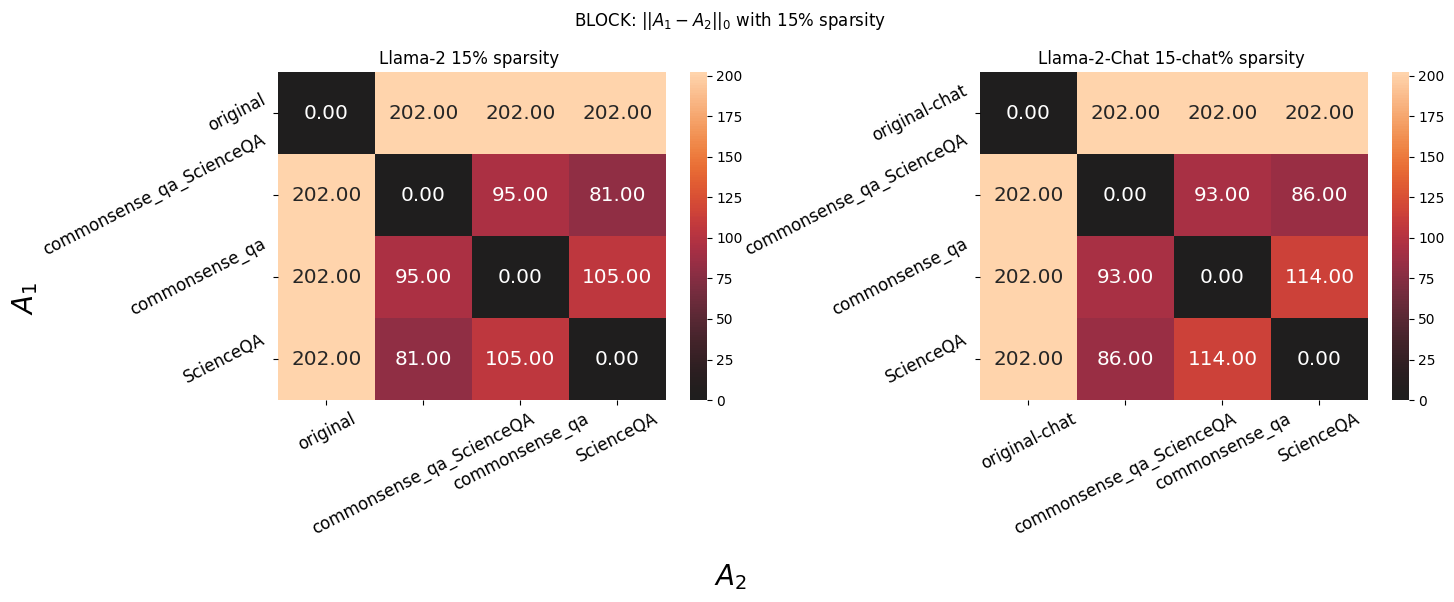

In [119]:
dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["cais/mmlu","derek-thomas/ScienceQA"]]
dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"]]
module = "|W|_0"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"]}
sparsity_model = {"15":["15","15-chat"]}
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
plt.clf()
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
#llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
for sparsity in sparsity_model:
    for style in ["block"]:
        print(style)
        for dataset_combine in dataset_both:
            figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")
            for ratio_idx, ratio in enumerate(sparsity_model[sparsity]):
                newFolder = "_".join([d.split('/')[-1] for d in dataset_combine])
                if ratio.split("-")[-1] == "chat":  
                    original = "original-chat"
                else:
                    original = "original"
                dataset_name = [original, newFolder,dataset_combine[0],dataset_combine[1]]
                data = []
                idx = 0
                #figure, axis = plt.subplots(ncols=3,figsize=(15, 6),layout="tight")
                mix = np.array(all_distribution[module][original])
                for dataset in dataset_name:
                    dataset = dataset.split('/')[-1]
                    if dataset == "original" or dataset == "original-chat" :
                        data.append((dataset,np.array(all_distribution[module][dataset])))
                    else:
                        data.append((dataset,np.array(llm_pruner[style][ratio][dataset]))) 
                        diff = np.subtract(mix,data[-1][1])
                difference = []
                label = []
                for (d1,arr1) in data:
                    values = []
                    for (d2,arr2) in data:
                        M = l_0_norm(arr1-arr2)  #np.linalg.norm(arr1 - arr2,2) #
                        values.append(M) 
                    label.append(d1)
                    difference.append(values)
                if ratio.split("-")[-1] == "chat":
                    axis[ratio_idx].set_title(f"Llama-2-Chat {ratio}% sparsity ")
                else:
                    axis[ratio_idx].set_title(f"Llama-2 {ratio}% sparsity ")
                g = sns.heatmap(np.array(difference),  annot=True, fmt=".2f",center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[ratio_idx],xticklabels=label,yticklabels=label,annot_kws={"fontsize" : "x-large"})
                g.set_yticklabels(g.get_yticklabels(), rotation = 27,fontsize ="large")
                g.set_xticklabels(g.get_xticklabels(), rotation = 27,fontsize ="large")
            figure.suptitle(f"{style.upper()}: "+r"$||A_1 - A_2||_0$"+f" with {ratio.split('-')[0]}% sparsity")
            figure.supylabel(r"$A_1$", fontsize=20)
            figure.supxlabel(r"$A_2$", fontsize=20)
            #plt.savefig(f"result/distribution/albation_{style}_{ratio}_{newFolder}.png")
            plt.show()


## Albation compare architecture

block
	 15


<Figure size 640x480 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

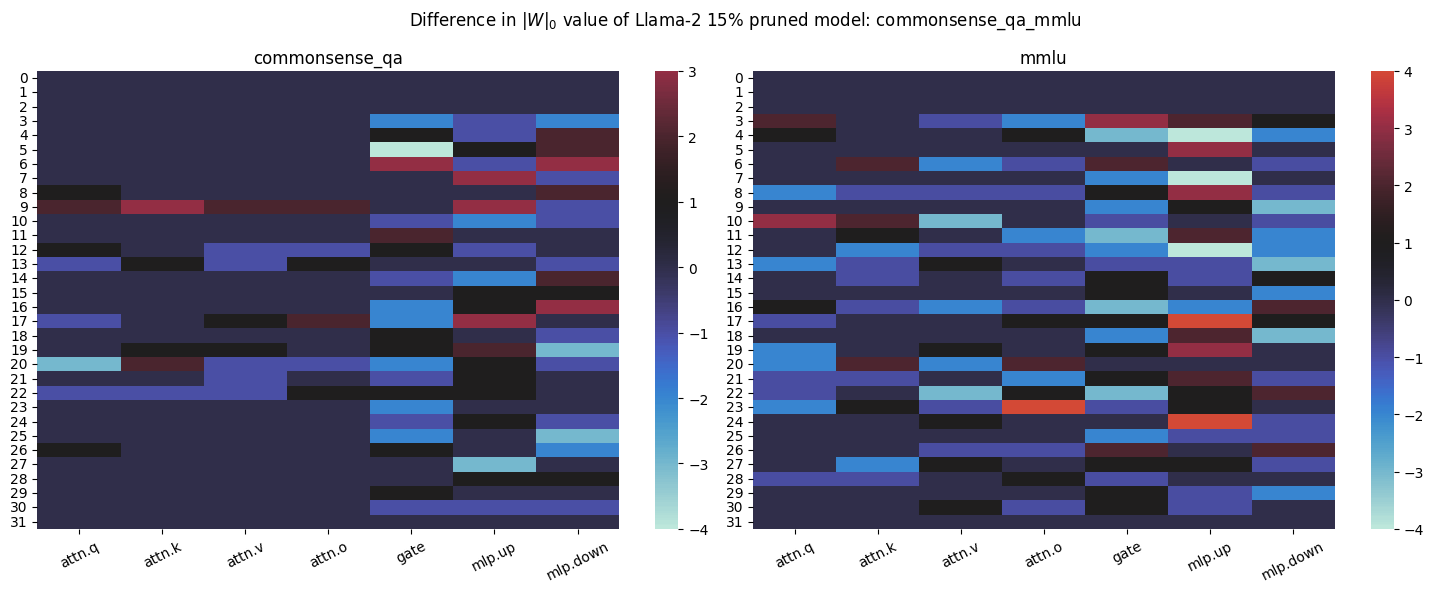

	 15


<Figure size 640x480 with 0 Axes>

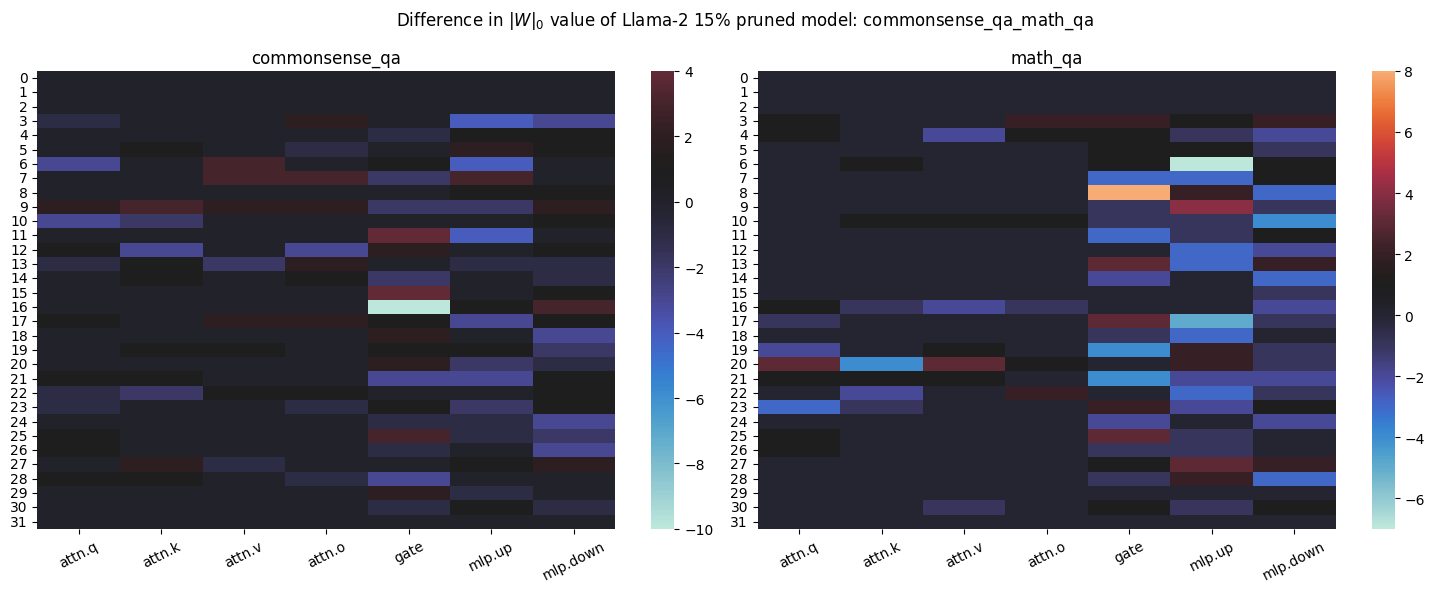

	 15


<Figure size 640x480 with 0 Axes>

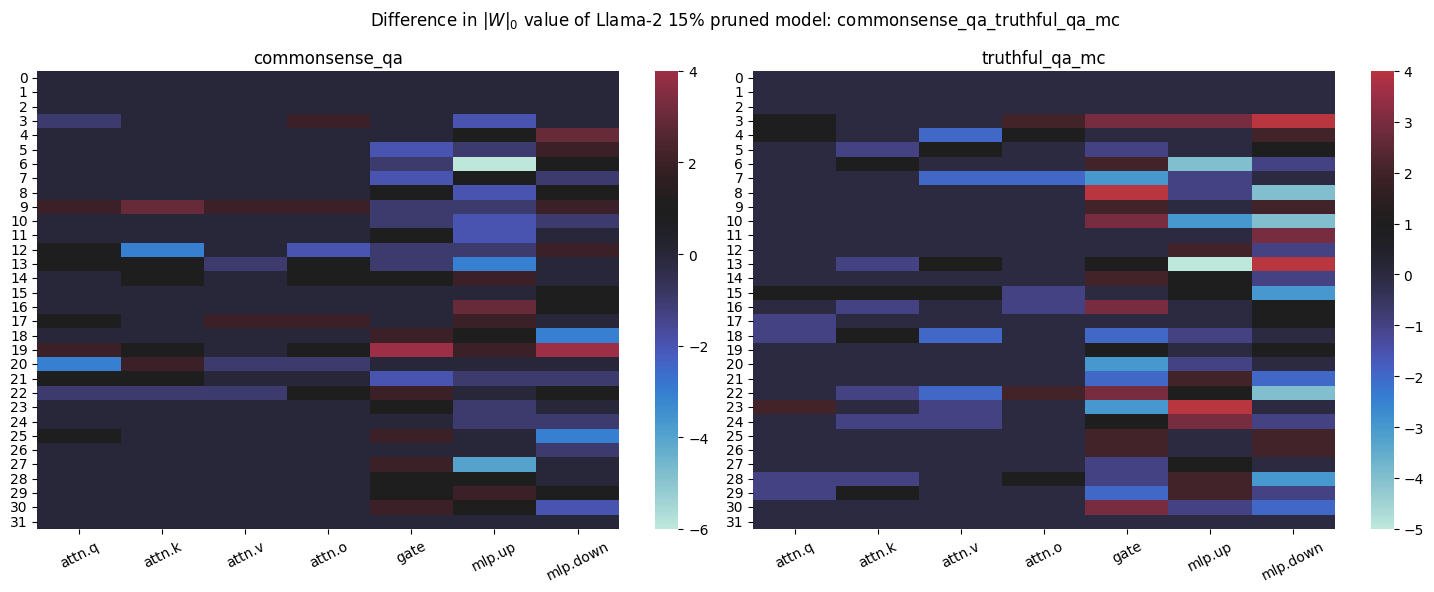

	 15


<Figure size 640x480 with 0 Axes>

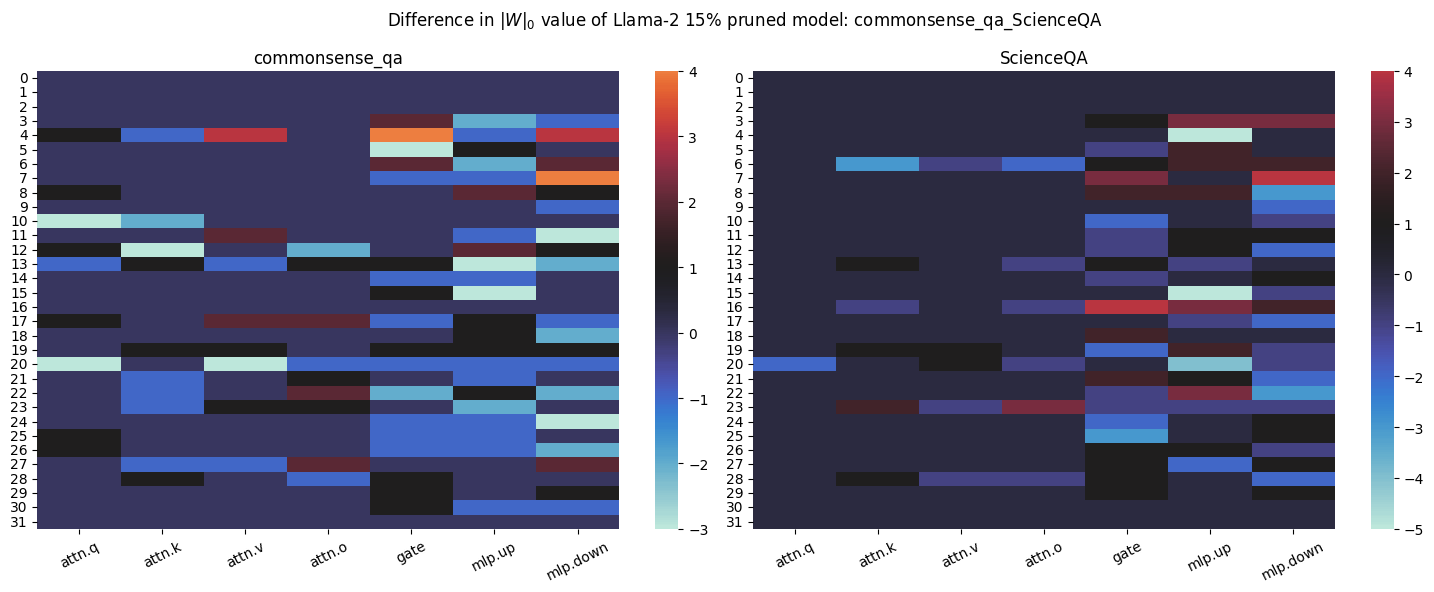

	 15


<Figure size 640x480 with 0 Axes>

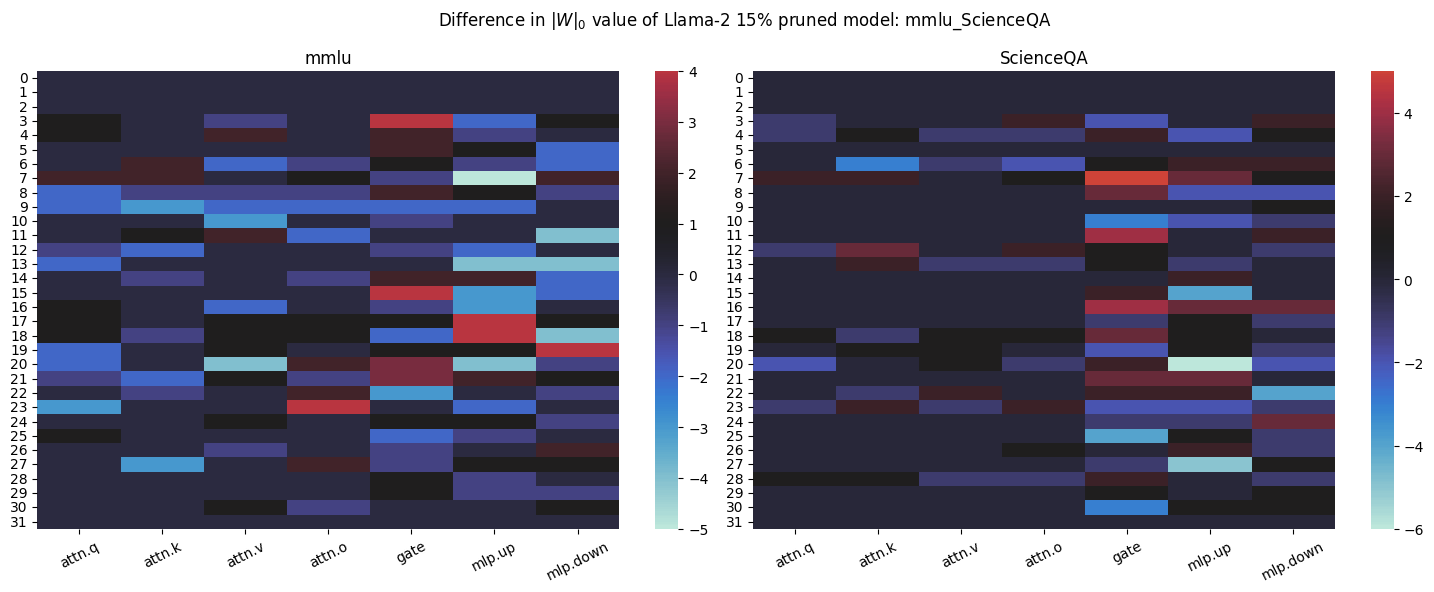

In [123]:
dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["cais/mmlu","derek-thomas/ScienceQA"]]
#dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"]]
module = "|W|_0"
style = "block"
sparsity_model = {"5":["5","5-chat"],"15":["15","15-chat"]}
sparsity_model = {"15":["15"]}
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
plt.clf()
original = all_distribution[module]["original"]
original_chat = all_distribution[module]["original-chat"]
#llm_pruner =  all_distribution[module]["LLM_Pruner"]
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
for sparsity in sparsity_model:
    for style in ["block"]:
        print(style)
        for dataset_combine in dataset_both:
            for ratio_idx, ratio in enumerate(sparsity_model[sparsity]):
                print(f"\t {ratio}")
                figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")
                newFolder = "_".join([d.split('/')[-1] for d in dataset_combine])
                dataset_name = [dataset_combine[0],dataset_combine[1]]
                mix = np.array(llm_pruner[style][ratio][newFolder])
                for idx,dataset in enumerate(dataset_name):
                    dataset = dataset.split('/')[-1]
                    diff = np.subtract(mix,np.array(llm_pruner[style][ratio][dataset]))
                    g = sns.heatmap(diff, center=1,cmap=sns.color_palette("icefire", as_cmap=True),ax=axis[idx],xticklabels=sub_layer)
                    g.set_xticklabels(g.get_xticklabels(), rotation = 27)
                    axis[idx].set_title(f"{dataset}")
                if ratio.split('-')[-1] == "chat":
                    figure.suptitle(r"Difference in $|W|_0$ value of Llama-2-chat "+ sparsity +"% pruned model: "+ newFolder)
                else:
                    figure.suptitle(r"Difference in $|W|_0$ value of Llama-2 "+ sparsity +"% pruned model: "+ newFolder)
                figure.tight_layout()
                #plt.savefig(f"result/distribution/albation_architecture_{ratio}_{newFolder}.png")
                plt.show()
                plt.clf()

# PCA and t-SNE comparison

Explained Variance Ratio: [0.46787883 0.16233445]


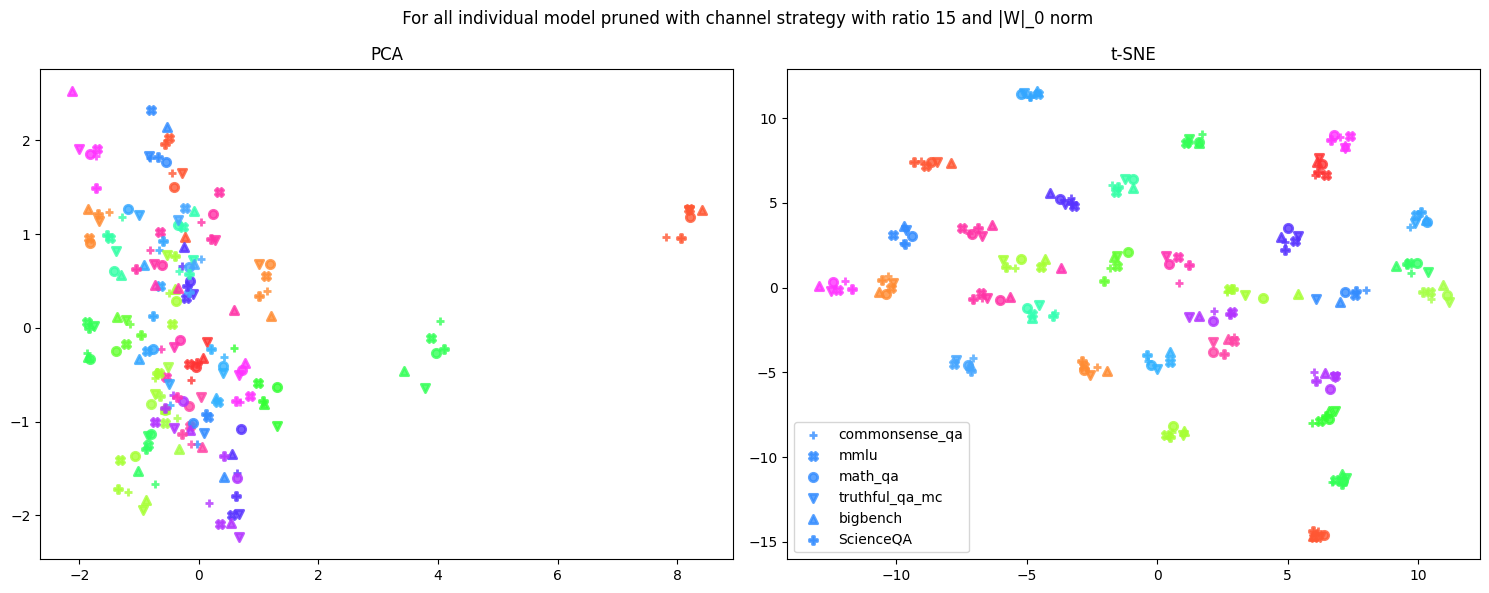

Explained Variance Ratio: [0.65492511 0.2830665 ]


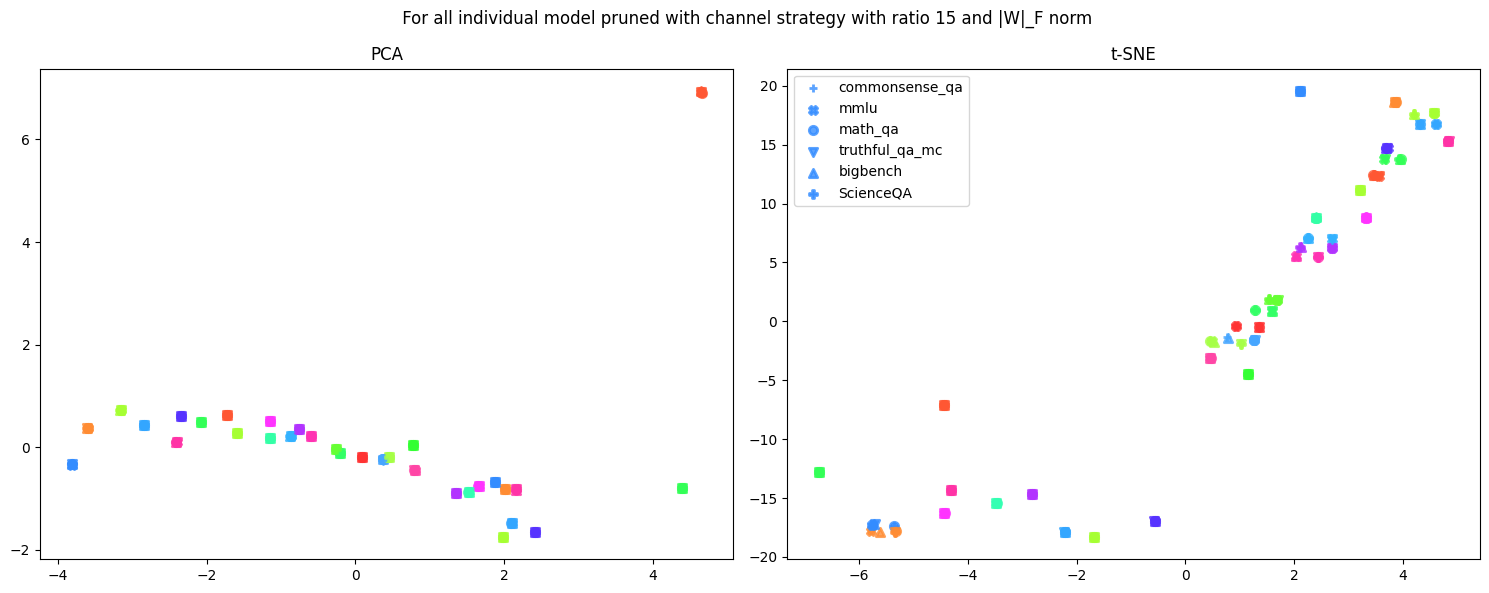

Explained Variance Ratio: [0.41347347 0.20304221]


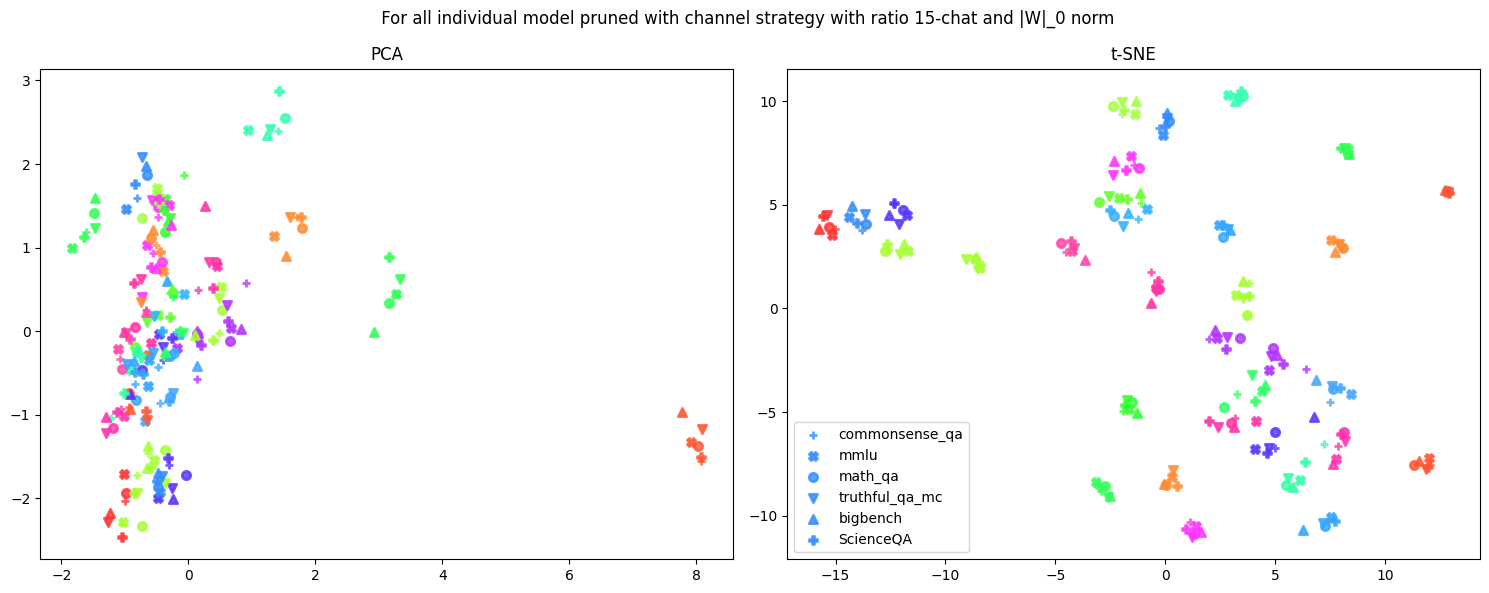

Explained Variance Ratio: [0.65380845 0.28425554]


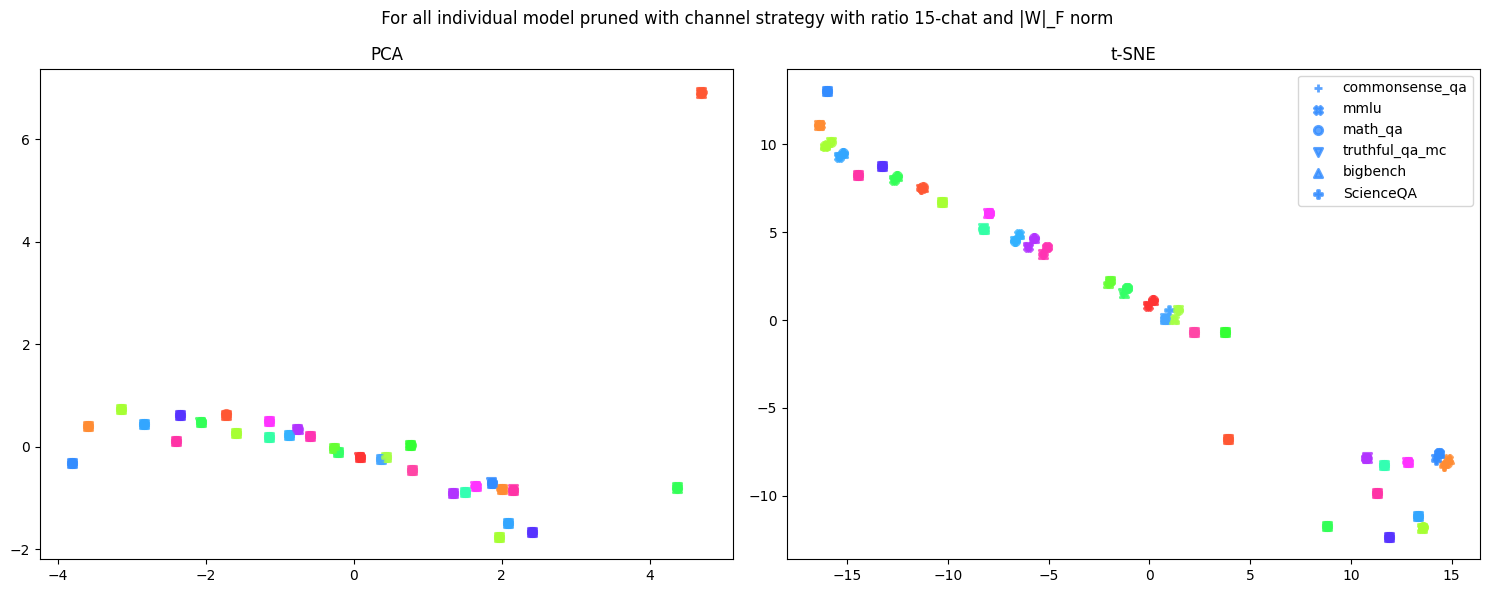

In [141]:
layers = np.arange(0,32,1)#[3:31]
for ratio in ["15","15-chat"]:
    for module in ["|W|_0", "|W|_F"]:
        style = "block"
        style = "channel"
        llm_pruner =  all_distribution[module]["LLM_Pruner"]
        #llm_pruner =  new_distribution[module]#["LLM_Pruner"]
        sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
        #for dataset in ["commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
        label = ["original","original-chat" ]
        if ratio.split("-")[-1] != "chat":  
            original = np.array(all_distribution[module]["original"])[layers,:]
        else:
            original = np.array(all_distribution[module]["original-chat"])[layers,:]
        label = [ ]
        #for idx, dataset_name in enumerate(["original","commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]):
        #for idx, dataset_name in enumerate(["commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]):
        label_idx = []
        all_data = ["commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]
        for idx, dataset_name in enumerate(all_data):
            dataset = dataset_name.split('/')[-1]
            label.append(dataset)
            label_idx.append(idx)
            if idx == 0:
                if dataset == "original":
                    X = original
                    y = np.zeros(X.shape[0])
                else:
                    X_new = (np.array(llm_pruner[style][ratio][dataset])[layers,:])
                    X =  X_new#.flatten().reshape(-1,1)
                    y = np.zeros(X_new.shape[0])
                continue
            X_new =  (np.array(llm_pruner[style][ratio][dataset])[layers,:])
            #X_new = X_new.flatten().reshape(-1,1)
            X = np.append(X, X_new, axis=0)
            y_new = np.ones(X_new.shape[0])*(idx)
            y = np.append(y, y_new, axis=0)
        '''y = np.ones(original.shape)
        for i in range(original.shape[0]):
            y[i,:]=y[i,:]*i
        y= y.flatten()'''
        # Standardize the feature matrix (mean center and scale)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        # Perform PCA
        n_components = 2  # Number of components to keep
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        tsne = TSNE(n_components=n_components, random_state=42, method="exact")
        X_tsne = tsne.fit_transform(X_scaled)
        # Explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_
        # Print the explained variance ratio
        print("Explained Variance Ratio:", explained_variance_ratio)
        figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")

        # Create a scatter plot of the data using the first two principal components
        colors = ["pink",'navy', 'turquoise', 'orange', "green", "red" ,"pink"]
        markers = ["+","X","o","v","^","P","D"]
        colors = [
            "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
            "#FF33FF", "#33FFB2", "#B233FF", "#33FF33", "#FF46A6", "#46A6FF", "#A6FF46", "#FF3333",
            "#33FF66", "#66FF33", "#FF33B2", "#B233FF", "#33B2FF", "#FF33FF", "#33FFA6", "#A6FF33",
            "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
        ]

        lw = 2
        #for color, i, target_name in zip(colors, np.arange(original.shape[0]), np.arange(original.shape[0])):
        for marker, i, target_name in zip(markers, label_idx, label):
            x_pca_0, x_pca_1 = X_pca[y == i, 0], X_pca[y == i, 1]
            x_tsne_0, x_tsne_1 = X_tsne[y == i, 0], X_tsne[y == i, 1]
            for idx, (color, layer) in enumerate(zip(colors,layers)):
                if layer == layers[-1]:
                    axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                            label=target_name)
                    axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                            label=target_name)
                else:
                    axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
                    axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
        axis[0].set_title(f"PCA")
        axis[1].set_title(f"t-SNE")
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        figure.suptitle(f" For all individual model pruned with {style} strategy with ratio {ratio} and {module} norm")
        plt.show()


# PCA and t-SNE for Mixed Model

In [144]:
#dataset_both = [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","derek-thomas/ScienceQA"]]
layers = np.arange(0,32,1)#[3:31]
module = "|W|_F"
ratio  = "15"
llm_pruner =  new_distribution[module]#["LLM_Pruner"]
sub_layer = ["attn.q", "attn.k", "attn.v", "attn.o","gate","mlp.up", "mlp.down"]
style = "block"
original = np.array(all_distribution[module]["original"])[3:31,:]
#for dataset in ["commonsense_qa","cais/mmlu","math_qa","EleutherAI/truthful_qa_mc","tasksource/bigbench","derek-thomas/ScienceQA"]:
for data in [["commonsense_qa","cais/mmlu"],["commonsense_qa","math_qa"],["commonsense_qa","EleutherAI/truthful_qa_mc"],["commonsense_qa","derek-thomas/ScienceQA"],["cais/mmlu","derek-thomas/ScienceQA"],["math_qa","derek-thomas/ScienceQA"]]:
    newFolder = "_".join([d.split('/')[-1] for d in data])
    X = np.array(llm_pruner[style][ratio][newFolder])[3:31,:]
    #X = original
    y = np.zeros(X.shape[0])
    #X =np.append(X, np.array(llm_pruner[style][ratio][newFolder])[3:31,:], axis=0)
    #y = np.append(y, np.ones(X_new.shape[0]), axis=0)# Target
    label = [newFolder]
    for idx, dataset_name in enumerate(data):
        dataset = dataset_name.split('/')[-1]
        label.append(dataset)
        #X_new =  original - np.array(llm_pruner[style][ratio][dataset])#[3:31,:]
        X_new =  np.array(llm_pruner[style][ratio][dataset])[layer,:]
        X = np.append(X, X_new, axis=0)
        y_new = np.ones(X_new.shape[0])*(idx+1)
        y = np.append(y, y_new, axis=0)
    # Standardize the feature matrix (mean center and scale)
    scaler = StandardScaler()
    X_scaled = X#scaler.fit_transform(X)

    # Perform PCA
    n_components = 2  # Number of components to keep
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    tsne = TSNE(n_components=n_components, random_state=42, method="exact")
    X_tsne = tsne.fit_transform(X_scaled)
    # Explained variance ratio
    explained_variance_ratio_pca = pca.explained_variance_ratio_

    # Print the explained variance ratio
    print("Explained Variance Ratio:", explained_variance_ratio_pca)
    figure, axis = plt.subplots(ncols=2,figsize=(15, 6),layout="tight")

    # Create a scatter plot of the data using the first two principal components
    colors = ['navy', 'turquoise', 'darkorange']
    # Create a scatter plot of the data using the first two principal components
    markers = ["^","X","o","+","v","^","P","D"]
    colors = [
        "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
        "#FF33FF", "#33FFB2", "#B233FF", "#33FF33", "#FF46A6", "#46A6FF", "#A6FF46", "#FF3333",
        "#33FF66", "#66FF33", "#FF33B2", "#B233FF", "#33B2FF", "#FF33FF", "#33FFA6", "#A6FF33",
        "#FF5733", "#33FF57", "#5733FF", "#FF33A6", "#33A6FF", "#A6FF33", "#FF8C33", "#338CFF",
    ]

    lw = 2
    #for color, i, target_name in zip(colors, np.arange(original.shape[0]), np.arange(original.shape[0])):
    for marker, i, target_name in zip(markers, label_idx, label):
        x_pca_0, x_pca_1 = X_pca[y == i, 0], X_pca[y == i, 1]
        x_tsne_0, x_tsne_1 = X_tsne[y == i, 0], X_tsne[y == i, 1]
        for idx, (color, layer) in enumerate(zip(colors,layers)):
            if layer == layers[-1]:
                axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                        label=target_name)
                axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw,
                        label=target_name)
            else:
                axis[0].scatter(x_pca_0[idx], x_pca_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
                axis[1].scatter(x_tsne_0[idx],x_tsne_1[idx], color=color,marker=marker, alpha=.8, lw=lw)
    axis[0].set_title(f"PCA")
    axis[1].set_title(f"t-SNE")
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    figure.suptitle(f" For all individual model with {style} pruning strategy for {ratio} ratio with {module} norm")
    plt.show()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)